<a href="https://colab.research.google.com/github/Firas-95/GEO572-Project-E.St.Louis/blob/E.St.Louismodeldomain%2Ffiras/ESL_model_v2.7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>FloPy Regional Model Development</center>
The following script develops a regional MODFLOW model using FloPy and associated packages. The study domain is the Mahomet Aquifer in Illinois, particulary in the heavily irrigated region of Mason County. 

Note that you may not always have to compile MODFLOW, and you only have initialize code (#1) and import large files (#2) the first time you run the code in a session. Most of the time, you will only have to run #3 onward. 

# 0. Compile MODFLOW (DO NOT RUN UNLESS NECESSARY)


When using Google CoLab, you cannot simply use an existing MODFLOW executable, but have to compile a a new one for use in this environment. I have already compiled MODFLOW, but am currently unsure if it will work for everybody. Please do not run the following code unless you get an error that the MODFLOW file was not found (will occur when running the model). 

In [0]:
#!pip install https://github.com/modflowpy/pymake/zipball/master # install of the pymake package to compile MODFLOW

In [0]:
# Code to complile the MODFLOW executable
#import pymake
#def make_mf2005():
#    pymake.build_apps('mf2005')
#if __name__ == "__main__":
#    make_mf2005()
# Mf-NWT has more rubust ……
#import pymake
#def make_mfnwt():
#    pymake.build_apps('mfnwt')
#if __name__ == "__main__":
#    make_mfnwt()

# 1 Initializing the code


These few code blocks only have to be run at the beginning of the script or if a runtime connection is lost. See details for each below. 

## 1A. Install needed packages
There are three packages that must be installed in the CoLab environment to run this script. These include 

"pyproj", which allows for the conversion from WGS84 coordinates (as obtained from Google Earth), which are in lat/long decimal degrees, to Illimap coordinates, a specialized projection using Lambert Conformal Conic that is optimized for developing a model grid in the state of Illinois. 

"flopy" creates modflow executables, runs the model, and allows for manipulation of results.

"rasterio" allows for the reading of raster files, and is closely tied to the development of "flopy" input files


In [63]:
!pip install pyproj
!pip install flopy
!pip install rasterio

## 1B. Import packages

In [0]:
import flopy  # import flopy to develop, run, and analyze the model
from flopy.utils import Raster  # plot rasters from flopy
import matplotlib as mp
import pandas as pd
import pyproj  # change between WGS84 and Illimap coordinates
import rasterio  # import rasters
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as spo

# the following code authorizes you to access files on Google Drive
from google.colab import drive,files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

## 1C. Authenticate with Google
This will allow you to access shared files on my Google Drive or your own. 

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## 1D. Read the MODFLOW executable from Google Drive

Here you are going to download the MODFLOW executable from Daniel's Google Drive. This will show up in your temporary working directory for use later in the code. <b>We need to confirm whether this will work in CoLab, or if you need to compile a new version of MODFLOW each time.</b>

Note that this makes use of a key on your Google Drive sharable link for the file. This generally takes the form of: https://drive.google.com/file/d/**key**/view?usp=sharing, in this case, key = 1SwqsSCvyrnrCiopeEp52LBcZYNcgBT9V

In [0]:
downloaded = drive.CreateFile({'id':"1SwqsSCvyrnrCiopeEp52LBcZYNcgBT9V"}) # This is the key that is defined in the sharable link of a file on Google Drive
downloaded.GetContentFile('mf2005') # get the content from Google Drive and name it (let's stick with mf2005 here)

#downloaded = drive.CreateFile({'id':"1iThxRoGVhofLPd8HOF7Vn0awRVrXZcVb"}) # This is the key that is defined in the sharable link of a file on Google Drive
#downloaded.GetContentFile('mfnwt') # get the content from Google Drive and name it (let's stick with mf2005 here)

Now we need to copy the executable into a location where we can later run it. Note that the "!" nomenclature is a shell command, beyond the scope of this course to learn that!

In [0]:
!cp mf2005 /usr/local/bin
!chmod 755 /usr/local/bin/mf2005

#!cp mfnwt /usr/local/bin
#!chmod 755 /usr/local/bin/mfnwt

# 2 Import the big stuff


We don't want to repeatedly import large files for fear of Google revoking our CoLab priveleges for a few hours. Once or twice isn't a big deal, but repeatedly might be an issue. Let Daniel know if this happens- there are ways to reduce our file sizes. 

For now, the "big stuff" includes a DEM of Illinois and the river excel file we worked with last time. 

## 2A. Import the DEM

In [0]:
# first import the land surface .tif from Google Drive
downloaded = drive.CreateFile({'id':"1389l8sgQ8-tsmIZuZosaqvbqpHY40n6l"}) # ft above msl, works best for most groups, spiky in Mason County 
downloaded.GetContentFile('landsurface_el.tif')

# first import the bedrock elevation .tif from Google Drive
downloaded = drive.CreateFile({'id':"1EZgZDjjILzvRzvY9nf0Qp0NHmspRq4kP"})   
downloaded.GetContentFile('bedrock_el.tif')

# read in percent thickness of coarse grain for each model layer
downloaded = drive.CreateFile({'id':"18Kw3O6qCzIJ2L6KrVnRPIhea_F8VwyWn"})   
downloaded.GetContentFile('percentl1.tif')

downloaded = drive.CreateFile({'id':"1oZinFPKrGY-FXoE7Zu0okFpAAOe_bwau"})   
downloaded.GetContentFile('percentl2.tif')

downloaded = drive.CreateFile({'id':"1FqVEr4m_ElUyEZeyfnCMwVGDfUqavJZH"})   
downloaded.GetContentFile('percentl3.tif')

downloaded = drive.CreateFile({'id':"1KiHS9TLSP1GAVTjaaJZS4BAwF6gnUeDu"})   
downloaded.GetContentFile('percentl4.tif')

downloaded = drive.CreateFile({'id':"1Z-9EyaAK1NKnRHAlnyGYkI3suvBFC2I6"})   
downloaded.GetContentFile('percentl5.tif')

downloaded = drive.CreateFile({'id':"1pcB9aJpJGfkXOKz10rhs6MpWkQL1_dqr"})   
downloaded.GetContentFile('percentl6.tif')

downloaded = drive.CreateFile({'id':"1Fnh0HIKbUj7pEtlsUKR_Sr7WwfYzWul5"})   
downloaded.GetContentFile('percentl7.tif')

downloaded = drive.CreateFile({'id':"106JacgpwSA3wVAGcBIzGdc8rDVUB6dh7"})   
downloaded.GetContentFile('percentl8.tif')

downloaded = drive.CreateFile({'id':"1WJjhVJ_KSBhZDrgzY3YteNjxaz5nxBid"})   
downloaded.GetContentFile('percentl9.tif')

## 2B. Import the river file

In [0]:
# first import the Excel file from Google Drive
downloaded = drive.CreateFile({'id':"1JsAiGG4RvcfYrQtfgXRW9ZVfAkQ1yRVu"})
downloaded.GetContentFile('rivers_625.csv')

# 3 Create MODFLOW  packages

## 3A. Model Set-up

### 3Ai. Define the Model Domain

In [70]:
#ESL project area
sw_lat = 38.4  #southwest latitude
sw_long = -90.25  #southwest longitude
ne_lat = 39  #northeast latitude
ne_long = -89.85  #northeast longitude

illimap = {
    'proj': 'lcc',  # Lambert Conformal Conic
    'ellps': 'clrk66',
    'lon_0': -89.5,
    'lat_0': 33,
    'lat_1': 33,
    'lat_2': 45,
    'x_0': 2999994 * 0.3048006096012192,
    'y_0': 0
}

prj = pyproj.Proj(illimap)

wgs84 = pyproj.Proj("epsg:4326")

nex, ney = pyproj.transform(wgs84, illimap, ne_lat, ne_long)
swx, swy = pyproj.transform(wgs84, illimap, sw_lat, sw_long)

#  convert the Lambert coordinates from meter to ft
nex, ney = round(nex / 0.3048006096012192, -4), round(ney / 0.3048006096012192,
                                                      -4)
swx, swy = round(swx / 0.3048006096012192, -4), round(swy / 0.3048006096012192,
                                                      -4)
print(nex, ney, swx, swy)

2900000.0 2180000.0 2790000.0 1960000.0


### 3Aii. Define spatial and temporal discretization

In [0]:
# Assign Discretization variables
Lx = nex - swx  # Width of the model domain
Ly = ney - swy  # Height of the model domain
nlay = 10  # Number of model layers
dx = 1000
dy = 1000
nrow = int(Ly / dy)  # Number of rows
ncol = int(Lx / dx)  # Number of columns

nper = 1  #specify number of stress periods
steady = [True]  #specify if stress period is transient or steady-state

### 3Aiii. Define river elevations



In [72]:
# import stage, lambert x, lambert y
dfriv = pd.read_csv('rivers_625.csv')

# trim dataframe with river information to the model domain
dfriv = dfriv.loc[dfriv['lamx'] < nex]
dfriv = dfriv.loc[dfriv['lamy'] < ney]
dfriv = dfriv.loc[dfriv['lamx'] > swx]
dfriv = dfriv.loc[dfriv['lamy'] > swy]
# assign all rivers to the upper layer
dfriv['lay'] = 0
'''convert lamx to column and lamy to row (determine the exact position of rivers in the model)'''
# np.trunc() can round decimals to integers
dfriv['row'] = np.trunc((ney - dfriv['lamy']) / dy).astype('int')  
dfriv['col'] = np.trunc((dfriv['lamx'] - swx) / dx).astype('int')
# define the river stage
dfriv['stage'] = dfriv['rvr_stg']
#define the conductance
dfriv['cond'] = 5000.  # unit: ft^2/d
"""define the river bottom
The average depth is around 20 ft.
The extreme flooding depth is around 40 ft.
(Source: USGS 07010000 Mississippi River at St. Louis, MO)
https://waterdata.usgs.gov/mo/nwis/dv?cb_00065=on&cb_80155=on&format=gif_default&site_no=07010000&referred_module=sw&period=&begin_date=2001-04-01&end_date=2020-04-16"""
dfriv['bot'] = dfriv['stage'] - 20
# drop unneeded files
dfriv = dfriv.drop(
    ['STR_ORD_MI', 'STR_ORD_MA', 'SUM_LENGTH', 'rvr_stg', 'lamx', 'lamy'],
    axis=1)

#  grouping repetitive river data
# groupby() can combine Dataframe indices with the same coordinates.
dfriv = dfriv.groupby(['lay', 'row', 'col'], as_index=False).mean() 
print(dfriv.head(5))

   lay  row  col  stage    cond    bot
0    0   39    9  417.0  5000.0  397.0
1    0   40   11  417.0  5000.0  397.0
2    0   41   12  417.0  5000.0  397.0
3    0   41   35  408.0  5000.0  388.0
4    0   42   14  417.0  5000.0  397.0


### 3Aiv. Define top and bottom elevations

In [0]:
"""Import the surface and bedrock DEM and assign the elevation for each cell
on the top or bottom layer in our model."""
# Now load the raster using FloPy's built in Raster toolbox
illinoisdem = Raster.load("landsurface_el.tif")
bedrock = Raster.load("bedrock_el.tif")

# Crop the DEM to the model domain
illinoisdem.crop([(swx, swy), (swx, ney), (nex, ney), (nex, swy)])
bedrock.crop([(swx, swy), (swx, ney), (nex, ney), (nex, swy)])
# Define centroid of the southwestern most cell
startx = swx + dx / 2
starty = swy + dy / 2
# Calculate the x and y coordinates for the centroid of each cell
xc = np.arange(swx + dx / 2, nex + dx / 2, dx)  # np.arange(start,end,interval)
yc = np.arange(swy + dy / 2, ney + dy / 2, dy)
# Create a grid of the x coordinate of each centroid and the y coordinate
xarr, yarr = np.meshgrid(xc, yc)
# resample the topo raster to the grid of centroids of the model
topgrid = illinoisdem.resample_to_grid(xarr, yarr, 1, method='nearest')
bedrock = bedrock.resample_to_grid(xarr, yarr, 1, method='nearest')

# We just built our top elevation upside down, let's flip it
topgrid = np.flipud(topgrid)
bedrockgrid = np.flipud(bedrock)
"""The grid does not extend past the boundaries of Illinois.
Inactivate cells west of the Mississippi River that were originally not present.
Note that because inactive cells would overlap with the river boundaries, this code pushes inactive cells to the west by 2 cells."""
maxrow = topgrid.shape[0]  # in our model maxrow =220
maxcol = topgrid.shape[1]  # in our model maxcol =110
# Create ibound as array of ints (1), indicating all cells are active
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
for row in np.arange(maxrow, 0, -1):
    # how far west to shift inactive cell
    counter = 0
    for col in np.arange(maxcol, 0, -1):
        if topgrid[row - 1, col - 1] <= -50:  # "row-1" is because python indices start from 0
            counter += 1
            topgrid[row - 1, col - 1] = topgrid[row - 1,
                                                col]  # "backfill" the data
            bedrockgrid[row - 1, col - 1] = bedrockgrid[row - 1, col]
            if counter >= 4:  # only backfill 4 grids on the maximum
                ibound[:, row - 1, col - 1] = 0

In [0]:
"""Define the top of river cells. Define the bottom of each layer."""
# Set the top of Layer 1 = River Elevation
for index, row in dfriv.iterrows():
    topgrid[int(row['row']), int(row['col'])] = row['stage']
# make sure that all layers （combined) are at least 9 ft thick
diff = topgrid - bedrockgrid
diff[diff <= 9.0] = 9.0
# each layer is the same thickness, we need 9 glacial layers
laythick = diff / 9
#calculate the bottom of each layer
lay1bot = topgrid - laythick
lay2bot = topgrid - 2 * laythick
lay3bot = topgrid - 3 * laythick
lay4bot = topgrid - 4 * laythick
lay5bot = topgrid - 5 * laythick
lay6bot = topgrid - 6 * laythick
lay7bot = topgrid - 7 * laythick
lay8bot = topgrid - 8 * laythick
lay9bot = topgrid - 9 * laythick
lay10bot = lay9bot - 50.
botgrids = [
    lay1bot, lay2bot, lay3bot, lay4bot, lay5bot, lay6bot, lay7bot, lay8bot,
    lay9bot, lay10bot
]

### 3Av. Assign hydrualic conductivity

In [0]:
"""Adjust this conductivity"""

# assign hydrualic conductivity in ft/day
kvc = 30 # predominantly very coarse
kc = 4  # predominantly coarse
kf = 0.05  # predominantly fine
kb = 20  # bedrock

# determine how to assign hydrualic conductivity
threshold1 = 40  # anything above this will be assigned kc and below kf
threshold2 = 20 # anything above this will be assigned kvc and below kc

def kloader(rastername, k1, k2, threshold):
    percent = Raster.load(rastername)  # load raster
    percent.crop([(swx, swy), (swx, ney), (nex, ney),
                  (nex, swy)])  # crop array
    percentgrid = percent.resample_to_grid(
        xarr, yarr, 1, method='nearest')  # resample to model grid
    percentgrid = np.flipud(percentgrid)  # flip the grid
    maxrow = percentgrid.shape[0]
    maxcol = percentgrid.shape[1]
    for row in np.arange(maxrow, 0, -1):
        for col in np.arange(maxcol, 0, -1):
            if percentgrid[row - 1, col - 1] < -10:
                percentgrid[row - 1, col - 1] = percentgrid[row - 1, col]
    for row in np.arange(maxrow, 0, -1):
        for col in np.arange(maxcol, 0, -1):
            if percentgrid[row - 1, col - 1] >= threshold:
                percentgrid[row - 1, col - 1] = k1  # assign very coarse k value
                continue
            else:
                percentgrid[row - 1, col - 1] = k2
    return percentgrid
  

In [0]:
''' computing the hydraulic conductivity of the model '''
kl1 = kloader('percentl1.tif', kc, kf, threshold1)
kl2 = kloader('percentl2.tif', kc, kf, threshold1)
kl3 = kloader('percentl3.tif', kc, kf, threshold1)
kl4 = kloader('percentl4.tif', kc, kf, threshold1)
kl5 = kloader('percentl5.tif', kc, kf, threshold1)   
kl6 = kloader('percentl6.tif', kc, kf, threshold1)
kl7 = kloader('percentl7.tif', kvc, kc, threshold2)
kl8 = kloader('percentl8.tif', kvc, kc, threshold2)
kl9 = kloader('percentl9.tif', kvc, kc, threshold2)
kl10 = kl9 - kl9 + kb

khlayers = [kl1, kl2, kl3, kl4, kl5, kl6, kl7, kl8, kl9, kl10]
kvlayers = np.divide(khlayers, 10.)

''' computing the Tranmsissivty of the model based on hydraulic conductivity'''
# each layer has the same thickness accounting for 9 glacial layers 
T1 = khlayers[0]*laythick
T2 = khlayers[1]*laythick
T3 = khlayers[2]*laythick
T4 = khlayers[3]*laythick
T5 = khlayers[4]*laythick
T6 = khlayers[5]*laythick
T7 = khlayers[6]*laythick
T8 = khlayers[7]*laythick
T9 = khlayers[8]*laythick
T10 = khlayers[9]*50 # do we need to include the bedrock layer? 

Tlayers = [T1, T2, T3, T4, T5, T6, T7, T8, T9, T10] # arranging the values in a list
T_total = T1 + T2 + T3 + T4 + T5 + T6 + T7 + T8 + T9 + T10 # computing the total transmissivity by summing each layer

###3Avi. Well pumpage data cleansing

In [78]:
"""Remove any item that loses data or does not meet the model requirement."""
def modify_pumpage(year:str):
  dfpump = pd.read_csv(
      'https://raw.githubusercontent.com/Firas-95/GEO572-Project-E.St.Louis/class_example/yiquan/pumping/Modified_Pumpage_Data_ESL.csv'
      )
  dfpump.rename(columns={'depth_total_last_known':'depth'}, inplace = True)
  list_drop = []
  for ind, row in dfpump.iterrows():
      # 1. drop items with too large depth
      if row['depth'] > 150:
          list_drop.append(ind)
          continue
      # 2. drop items if their x-coordinates exceed the model boundary
      elif row['lam_x'] > nex or row['lam_x'] < swx:
          list_drop.append(ind)
          continue
      # 3. drop items if their y-coordinates exceed the model boundary
      elif row['lam_y'] > ney or row['lam_y'] < swy:
          list_drop.append(ind)
  dfpump = dfpump.drop(list_drop)
  # 4. drop item with no value
  dfpump = dfpump.dropna(subset=["lam_x", "lam_y","depth",year],how='any')
  modified_pump = dfpump[["lam_x","lam_y","depth",year]]
  modified_pump.index = range(len(modified_pump))
  return modified_pump

pump95 = modify_pumpage("1995")
print(pump95)

        lam_x      lam_y  depth         1995
0   2854450.0  2093457.0   91.0   24480000.0
1   2833677.0  2075353.0  111.0     180000.0
2   2854752.0  2079301.0  102.0   74479500.0
3   2854552.0  2079309.0  100.0   74479500.0
4   2854773.0  2079519.0  101.0   74479500.0
5   2853618.0  2081664.0  106.0   60340210.0
6   2853823.0  2081823.0   99.0  112349110.0
7   2853629.0  2081778.0  114.0  127476780.0
8   2853276.0  2063423.0  108.0  103565000.0
9   2854502.0  2063425.0  115.0   99599000.0
10  2854246.0  2063396.0  115.0   78492000.0
11  2853599.0  2063435.0  113.0  108129000.0
12  2851506.0  2052944.0  100.0  177105500.0
13  2851046.0  2052958.0  103.0  177105500.0
14  2851230.0  2053385.0   98.0  177105500.0
15  2851578.0  2053252.0   98.0  177105500.0
16  2851303.0  2053234.0   99.0  177105500.0
17  2830151.0  2115805.0  106.0   35166500.0
18  2840563.0  2106862.0  111.0   71000000.0
19  2840269.0  2106883.0  109.0   66040900.0
20  2839971.0  2106909.0  110.0   71000000.0
21  284687

In [79]:
dflostpump = pd.read_excel("https://github.com/Firas-95/GEO572-Project-E.St.Louis/blob/class_example/yiquan/pumping/ESL_lost_coordinates.xlsx?raw=true")
lat_list,long_list=dflostpump["lat"].values.tolist(),dflostpump["long"].values.tolist()
lat_list,long_list = pyproj.transform(wgs84, illimap,lat_list,long_list)
dflostpump["lam_x"],dflostpump["lam_y"]=[round(i/ 0.3048006096012192,0) for i in lat_list],\
                                        [round(j / 0.3048006096012192,0) for j in long_list]
dflostpump['row'] = np.trunc((ney - dflostpump['lam_y']) / dy).astype('int')  
dflostpump['col'] = np.trunc((dflostpump['lam_x'] - swx) / dx).astype('int')
dflostpump.rename(columns={1995:'1995'}, inplace = True)
dflostpump = dflostpump.reindex(columns=[ 'row', 'col', 'depth','1995'])
dflostpump['1995']=round(-dflostpump['1995']/7.48052/365,2)
print(dflostpump)

   row  col  depth       1995
0   40   39   91.0 -122026.53
1  137   21   96.0 -278348.53
2  137   31  105.5 -156396.35
3  130   25  110.0  -30288.72
4   61   47  115.0 -344273.19
5  111   25  113.0 -114452.52
6   46   23   92.0 -117199.38
7   84   68   91.0   -8965.75
8   44   26   92.0 -117199.38
9  137   23   96.0 -128186.83


In [80]:
"""Adjust the modified data to meet the input requirement."""
'''convert lamx to column and lamy to row (determine the exact position of wells in the model)'''
# np.trunc() can round decimals to integers
pump95['row'] = np.trunc((ney - pump95['lam_y']) / dy).astype('int')  
pump95['col'] = np.trunc((pump95['lam_x'] - swx) / dx).astype('int')
#  grouping repetitive river data
# groupby() can combine Dataframe indices with the same coordinates.
pump95 = pump95.groupby(['row', 'col'], as_index=False).mean() 
pump95['1995']=round(-pump95['1995']/7.48052/365,2) # unit ft/d, keep 2 digits
pump95 = pump95.drop(['lam_x','lam_y'],axis=1)

frames = [pump95,dflostpump]
pump95 = pd.concat(frames)
pump95.index = range(len(pump95))
print(pump95)
# pump95.to_csv("pump95.csv")
# files.download("pump95.csv")

    row  col       depth       1995
0    25  104   47.000000   -4394.98
1    47   33   97.250000  -24375.94
2    50   45   93.142857  -29553.08
3    54   35   83.000000  -42118.53
4    54   36   81.000000  -45781.01
5    55   36   84.000000  -41202.91
6    55   37   86.000000  -36624.81
7    64   40  106.000000  -19430.28
8    73   49  110.000000  -26003.61
9    73   50  110.000000  -25095.48
10   77   56  114.150000  -66249.83
11   77   57  112.000000 -106369.50
12   82   64   76.000000      -5.49
13   86   64   91.000000   -8965.75
14   98   63  106.333333  -36645.09
15  100   64  101.000000  -27277.97
16  104   43  111.000000     -65.92
17  116   63  110.500000  -38766.26
18  116   64  115.000000  -32612.74
19  126   61   98.333333  -64864.55
20  127   61  101.500000  -64864.55
21  129   54  108.000000  -15614.18
22  174    4  110.000000  -33533.40
23   40   39   91.000000 -122026.53
24  137   21   96.000000 -278348.53
25  137   31  105.500000 -156396.35
26  130   25  110.000000  -3

In [81]:
"""Build the pumpage data and put them in a list[[lay, row, col, flux]]."""
pumplist=[]
for ind, row in pump95.iterrows():
  a,b,c,d = int(row['row']),int(row['col']),row['depth'],row['1995']
  #print(a,b,c,d)
  # Judge how many layers can a pumping well can go into.
  for i in np.arange(9, 0, -1):
    if c > topgrid[a][b]-botgrids[i][a][b]:
      # Add pumpage data in the [lay, row, col, flux] format.
      pumplist.append([i,a,b,d])
      break
print(pumplist)

[[3, 25, 104, -4394.98], [8, 47, 33, -24375.94], [8, 50, 45, -29553.08], [5, 54, 35, -42118.53], [5, 54, 36, -45781.01], [6, 55, 36, -41202.91], [6, 55, 37, -36624.81], [6, 64, 40, -19430.28], [7, 73, 49, -26003.61], [7, 73, 50, -25095.48], [7, 77, 56, -66249.83], [8, 77, 57, -106369.5], [8, 82, 64, -5.49], [8, 86, 64, -8965.75], [8, 98, 63, -36645.09], [8, 100, 64, -27277.97], [7, 104, 43, -65.92], [8, 116, 63, -38766.26], [8, 116, 64, -32612.74], [8, 126, 61, -64864.55], [8, 127, 61, -64864.55], [7, 129, 54, -15614.18], [7, 174, 4, -33533.4], [8, 40, 39, -122026.53], [6, 137, 21, -278348.53], [7, 137, 31, -156396.35], [7, 130, 25, -30288.72], [8, 61, 47, -344273.19], [8, 111, 25, -114452.52], [8, 46, 23, -117199.38], [6, 84, 68, -8965.75], [9, 44, 26, -117199.38], [6, 137, 23, -128186.83]]


## 3B. Create the MODFLOW model object 

In [0]:
# Create a MODFLOW model object and run with MODFLOW 2005.
modelname = "my_model"  # name the model
m = flopy.modflow.Modflow(modelname, version='mf2005',
                          exe_name='mf2005')  # create model object m

## 3C. Append the discretization package to the model object

In [0]:
# length and time are feet (1) and days (4).
# See https://water.usgs.gov/ogw/modflow/MODFLOW-2005-Guide/index.html?dis.htm 
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=topgrid, botm=botgrids, 
                               itmuni = 4, lenuni = 1, 
                               nper=nper, steady=steady)

## 3D. Basic Package

In [0]:
#Create flopy bas object
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=topgrid)

## 3E. LPF Package

In [0]:
#define layer type as convertible (1) or confined (0), must be an integer
laytyp = np.zeros((nlay, ), dtype=np.int32)
#print(laytyp)  # result: [0 0 0 0 0 0 0 0 0 0]
# create the LPF object
lpf = flopy.modflow.ModflowLpf(model=m,
                               hk=khlayers,
                               vka=kvlayers,
                               laytyp=laytyp,
                               ipakcb=1)

## 3F. Boundary Conditions

### 3Fi. Recharge Package

In [0]:
"""Specify recharge zone based on hydraulic conductivity."""
rech = kl1.copy()
# Assume recharge is proportional to the conductivity. 

rech = np.where(rech == kc, 0.0015, 0.0007)
# ibound_zero = ibound[0]
ibound_zero = np.where(ibound[0] == 0)
# ibound_zero_col = np.where(ibound_zero == 0)[1]
for i in range(len(ibound_zero[0])):
    rech[ibound_zero[0][i], ibound_zero[1][i]] = 0

In [0]:
# assign recharge to the model
rch = flopy.modflow.mfrch.ModflowRch(model=m,nrchop=1,rech=rech)

### 3Fii. River Package

In [0]:
# put into a format that MODFLOW wants
arriv = dfriv.values
riverdata = {0: arriv}
# create river package
riv = flopy.modflow.mfriv.ModflowRiv(model=m,
                                     ipakcb=None,
                                     stress_period_data=riverdata)

### 3Fiii. Drain Package


In [89]:
"""Acquire a dataframe that contains all drain cells."""
drain = {
    'row': np.where(kl1 == kf)[0],
    'col': np.where(kl1 == kf)[1]
}  # np.where() returns all indices where the conductivity is low
dfdrn = pd.DataFrame(drain)
dfdrn['lay'] = 0
dfdrn['cond'] = kf*dx*dy/laythick.mean()  # conductance unit: ft^2/day
dfdrn['stage'] = topgrid[dfdrn['row'], dfdrn['col']]
dfdrn = dfdrn.reindex(columns=['lay', 'row', 'col', 'stage',
                               'cond'])  # rearrange the columns
print(dfdrn)

       lay  row  col       stage         cond
0        0    0    0  548.302490  5914.611942
1        0    0    1  553.819214  5914.611942
2        0    0    2  552.003784  5914.611942
3        0    0    3  562.338501  5914.611942
4        0    0    4  541.142212  5914.611942
...    ...  ...  ...         ...          ...
23717    0  219  105  450.316772  5914.611942
23718    0  219  106  468.960022  5914.611942
23719    0  219  107  448.542267  5914.611942
23720    0  219  108  428.716034  5914.611942
23721    0  219  109  419.235748  5914.611942

[23722 rows x 5 columns]


In [90]:
################# what did you drop here??
dfdrn_droplist = []
for ind, row in dfdrn.iterrows():
    if ibound[0][dfdrn.iloc[ind, 1]][dfdrn.iloc[ind, 2]] == 0:
        dfdrn_droplist.append(ind)
dfdrn = dfdrn.drop(dfdrn_droplist)
print(dfdrn)

       lay  row  col       stage         cond
0        0    0    0  548.302490  5914.611942
1        0    0    1  553.819214  5914.611942
2        0    0    2  552.003784  5914.611942
3        0    0    3  562.338501  5914.611942
4        0    0    4  541.142212  5914.611942
...    ...  ...  ...         ...          ...
23717    0  219  105  450.316772  5914.611942
23718    0  219  106  468.960022  5914.611942
23719    0  219  107  448.542267  5914.611942
23720    0  219  108  428.716034  5914.611942
23721    0  219  109  419.235748  5914.611942

[21946 rows x 5 columns]


In [0]:
# # # put into a format that MODFLOW wants
ardrn = dfdrn.values
draindata = {0: ardrn}
# create drain package
drn = flopy.modflow.mfdrn.ModflowDrn(model=m,
                                     ipakcb=None,
                                     stress_period_data=draindata)

### 3Fiv. Well Package

In [0]:
pumpagedata = {0: pumplist}
pum = flopy.modflow.mfwel.ModflowWel(model=m,
                                     ipakcb=None,
                                     stress_period_data=pumpagedata)

## 3G. Define output control

In [0]:
#create oc stress period data.
spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}
#create output control object
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=spd, compact=True)

## 3H. Solver

In [0]:
# We will start by using the PCG solver with default settings
#pcg = flopy.modflow.ModflowPcg(model=m)
pcg = flopy.modflow.ModflowPcg(model=m,
                               mxiter=200,
                               iter1=50,
                               hclose=1e-03,
                               rclose=1e-03,
                               relax=0.98,
                               damp=0.3)

## 3I. Plot model inputs (boundary conditions, elevations)

/usr/local/lib/python3.6/dist-packages/flopy/plot/map.py:525: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pa[list(idx[1:])] = 1


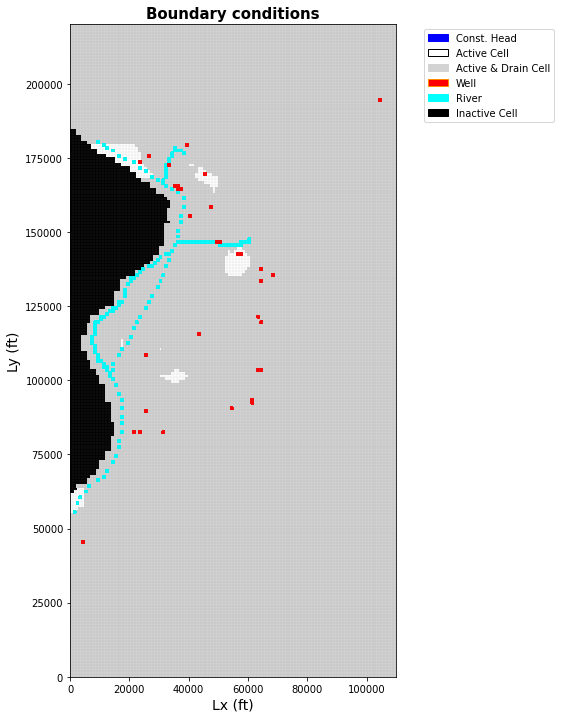

In [145]:
# '''Plot grid and boundary conditions'''
plt.figure(figsize=(12, 12),facecolor="white")  #create 12 x 12 figure
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid(linewidth=0.1)

ib = modelmap.plot_ibound()
dra = modelmap.plot_bc(ftype='DRN', color='lightgrey')
rvr = modelmap.plot_bc(ftype='RIV', color='aqua')
pup = modelmap.plot_bc(ftype='WEL',color='red',plotAll=True)
#add labels and legend
plt.xlabel('Lx (ft)', fontsize=14)
plt.ylabel('Ly (ft)', fontsize=14)
plt.title('Boundary conditions', fontsize=15, fontweight='bold')
plt.legend(handles=[
    mp.patches.Patch(color='blue', label='Const. Head', ec='blue'),
    mp.patches.Patch(color='white', label='Active Cell', ec='black'),
    mp.patches.Patch(color='lightgrey', label='Active & Drain Cell', ec='lightgrey'),
    mp.patches.Patch(color='red', label='Well', ec='darkorange'),
    mp.patches.Patch(color='cyan', label='River', ec='aqua'),
    mp.patches.Patch(color='black', label='Inactive Cell', ec='black')],
           bbox_to_anchor=(1.5, 1.0))
plt.show()

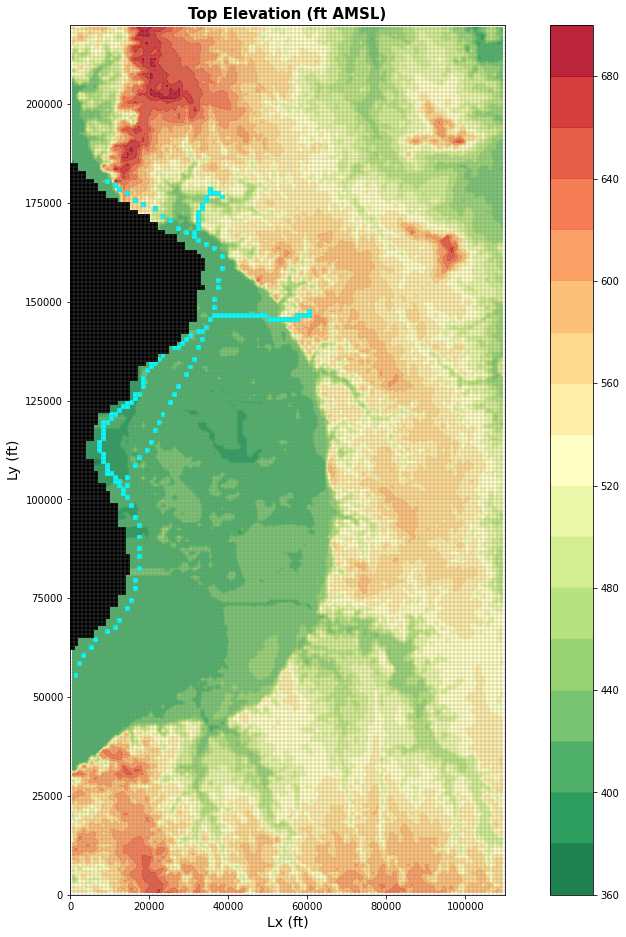

In [126]:
# """Plot top elevation"""
plt.figure(figsize=(16, 16),facecolor="white")  #create 16 x 16 figure
modelmap = flopy.plot.map.PlotMapView(
    model=m, layer=0)  #use plotmapview to attach plot to model
# Create meshgrid for the model, they will be used in the top elevation map.
# x and y are located on the centeroid of each grid
grid = modelmap.plot_grid(linewidth=0.3)
x = xc - np.min(xc) + dx / 2
y = yc - np.min(yc) + dy / 2
X, Y = np.meshgrid(x, y)
plt.colorbar(plt.contourf(X, Y, topgrid, 16, alpha=0.9,
                          cmap=plt.cm.RdYlGn_r))  # Plot the top elevation

rvr = modelmap.plot_bc(ftype='RIV', color='aqua')
ib = modelmap.plot_ibound()
#display parameters
plt.xlabel('Lx (ft)', fontsize=14)
plt.ylabel('Ly (ft)', fontsize=14)
plt.title('Top Elevation (ft AMSL)', fontsize=15, fontweight='bold')
plt.show()

In [0]:
"""Plot the transect we are concerned about in milestone 1."""
def plot_transect(rowcolflag=0, value=0):

  # rowcolflag indicates whether the transect is on the row or the column direction
  if rowcolflag == 0:
    plt.figure(figsize=(12, 5))  #create 12 x 5 figure
    modelxsect = flopy.plot.PlotCrossSection(
        model=m, line={"row": value})  #use plotmapview to attach plot to model
  elif rowcolflag == 1:
    plt.figure(figsize=(24, 5))  #create 24 x 5 figure
    modelxsect = flopy.plot.PlotCrossSection(
        model=m, line={"column": value})  #use plotmapview to attach plot to model      
  #create colormap of named colors
  colors =["saddlebrown", "gray","lightgoldenrodyellow"]#"darkgray","darkkhaki","beige",
  cmap = mp.colors.LinearSegmentedColormap.from_list("", colors)
  norm = mp.colors.LogNorm(vmin=kf, vmax=kvc)
  khlaynp = np.array(khlayers)
  lines = modelxsect.plot_array(khlaynp, norm=norm, cmap=cmap)
  modelxsect.plot_bc(ftype='DRN', color='darkred')
  modelxsect.plot_bc(ftype='RIV', color='aqua')
  modelxsect.plot_bc(ftype='WEL',color='darkorange')
  modelxsect.plot_ibound()
  plt.show()
  return


In [0]:
# # Plot the 3 east-west transects
# plot_transect(rowcolflag=0, value=64) # transect 4
# plot_transect(rowcolflag=0, value=104) # transect 5
# plot_transect(rowcolflag=0, value=116) # transect 6

In [0]:
# # Plot the 3 north-south transects
# plot_transect(rowcolflag=1, value=35) #transect 1
# plot_transect(rowcolflag=1, value=50) #transect 2
# plot_transect(rowcolflag=1, value=64) #transect 3

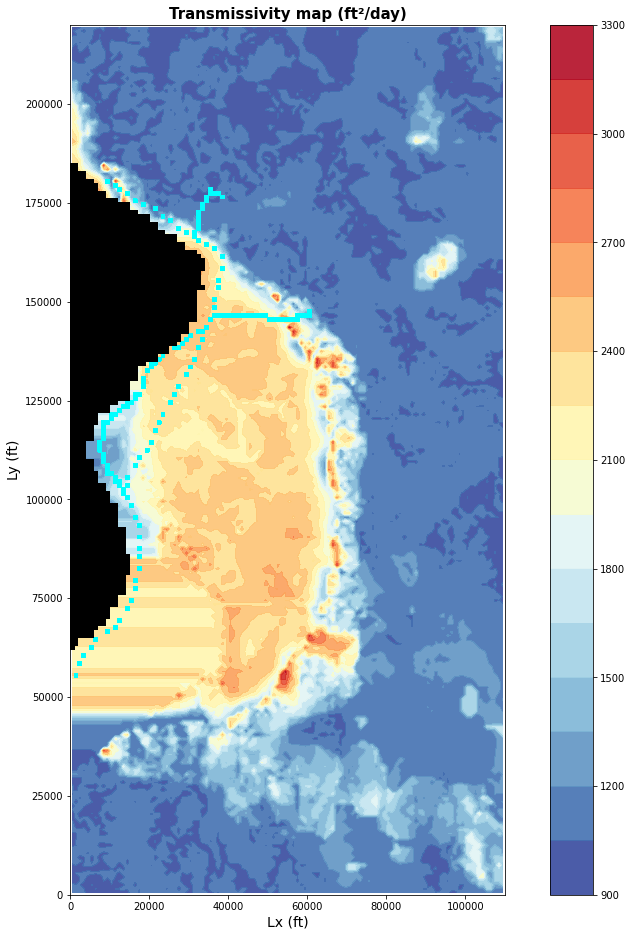

In [149]:
""" Plot Tranmsissivity map """
plt.figure(figsize=(16, 16),facecolor="white")  #create 16 x 16 figure
modelmap = flopy.plot.map.PlotMapView(
    model=m, layer=0)  #use plotmapview to attach plot to model
# Create meshgrid for the model, they will be used in the top elevation map.
# x and y are located on the centeroid of each grid
#grid = modelmap.plot_grid(linewidth=0.3)
x = xc - np.min(xc) + dx / 2
y = yc - np.min(yc) + dy / 2
X, Y = np.meshgrid(x, y)
plt.colorbar(plt.contourf(X, Y, T_total, 16, alpha=0.9,
                          cmap=plt.cm.RdYlBu_r))  # Plot the transmissivity

rvr = modelmap.plot_bc(ftype='RIV', color='aqua')
ib = modelmap.plot_ibound()
#display parameters
plt.xlabel('Lx (ft)', fontsize=14)
plt.ylabel('Ly (ft)', fontsize=14)
plt.title('Transmissivity map (ft²/day)', fontsize=15, fontweight='bold')
plt.show()

# 4 Write and run the MODFLOW model

In [100]:
# Write the model input
m.write_input()
# Execute the model run
success, mfoutput = m.run_model(pause=False, report=True)
# Report back if the model did not successfully complete
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following  executable to run the model: /usr/local/bin/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: my_model.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/05/02  5:47:28

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2020/05/02  5:47:39
 Elapsed run time: 10.662 Seconds

  Normal termination of simulation


# 5 Plot Output Data and model calibration

In [0]:
'''Extract binary data from head and flow files'''
#extract binary data from head file as flopy head object
headobj = flopy.utils.binaryfile.HeadFile(modelname + '.hds')
#extract head data from head object
head = headobj.get_data(totim=1.0)
# Set heads of inactivated cells to NAN (for plotting purpose)
head1=np.where(head[0]<0,np.nan,head[0])
head1=np.flipud(head1)  # data was upside down, let's flip it.

In [102]:
"Import historical groundwater head data and modify the format for further comparison."
dfhisthead = pd.read_excel('https://github.com/Firas-95/GEO572-Project-E.St.Louis/blob/master/flopy/EastStLouis_gwmassmeas.xlsx?raw=true')
dfhisthead=dfhisthead[["lat","long","y1995"]]
# Cut the items with no data
dfhisthead=dfhisthead.dropna(how='any')
# Cut the outliers for the historical data
dfhisthead= dfhisthead.loc[dfhisthead['lat'] < ne_lat]
dfhisthead = dfhisthead.loc[dfhisthead['long'] < ne_long]
dfhisthead = dfhisthead.loc[dfhisthead['lat'] > sw_lat]
dfhisthead = dfhisthead.loc[dfhisthead['long'] > sw_long]
# convert lat and long to lambert coorindates for historical data, then fit them into the model 
lat_list,long_list=dfhisthead["lat"].values.tolist(),dfhisthead["long"].values.tolist()
lat_list,long_list = pyproj.transform(wgs84, illimap,lat_list,long_list)
dfhisthead["lam_x"],dfhisthead["lam_y"]=[round(i/ 0.3048006096012192,0) for i in lat_list],\
                                        [round(j / 0.3048006096012192,0) for j in long_list]
dfhisthead['row'] = np.trunc((ney - dfhisthead['lam_y']) / dy).astype('int')  
dfhisthead['col'] = np.trunc((dfhisthead['lam_x'] - swx) / dx).astype('int')
#  grouping repetitive historical head data
# groupby() can combine Dataframe indices with the same coordinates.
dfhisthead = dfhisthead.groupby(['row', 'col'], as_index=False).mean()
dfhisthead['x']=dfhisthead['col']*dy+dy/2
dfhisthead['y']=220000-(dfhisthead['row']*dx+dx/2)
dfhisthead=dfhisthead.drop(["lat","long","lam_x","lam_y"],axis=1) 
model=[]
for index, row in dfhisthead.iterrows():
  model.append(head[0][int(row["row"])][int(row["col"])])
dfhisthead['model']=model
dfhisthead=dfhisthead.dropna(how='any')
print(dfhisthead.head(5))

   row  col    y1995        x         y       model
0   45   21  408.350  21500.0  174500.0  417.197540
1   45   26  401.660  26500.0  174500.0  396.761993
2   45   27  388.055  27500.0  174500.0  402.964722
3   46   23  396.580  23500.0  173500.0  387.911285
4   46   25  400.150  25500.0  173500.0  404.161285


/usr/local/lib/python3.6/dist-packages/flopy/plot/map.py:525: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pa[list(idx[1:])] = 1


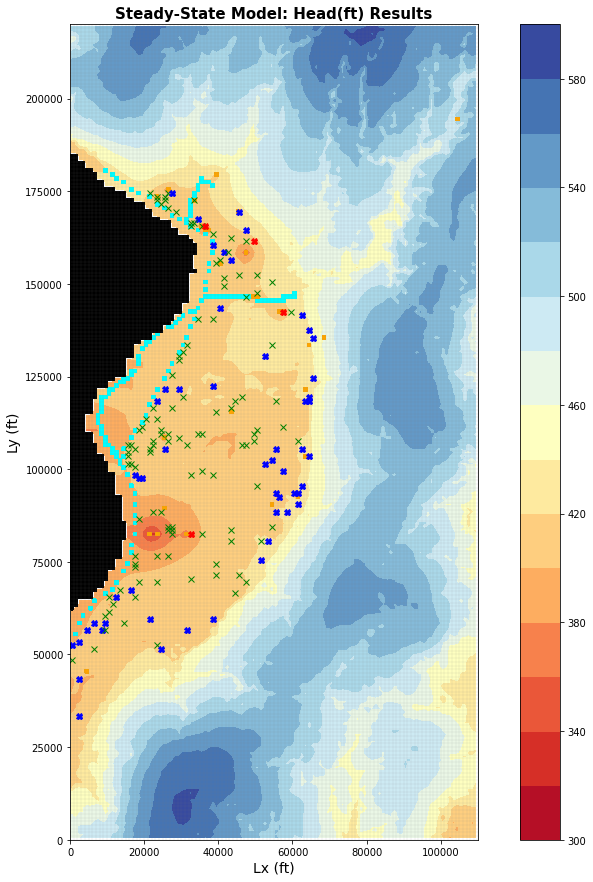

In [103]:
"""Plot results."""
plt.figure(figsize=(15, 15),facecolor="white")  #create 16 x 16 figure
modelmap = flopy.plot.map.PlotMapView(
    model=m, layer=0)  #use plotmapview to attach plot to model
contour_levels = np.linspace(300,600,10) #set contour levels for contouring head
# contour_levels = np.linspace(200,600,26) #set contour levels for contouring head
# head_contours = modelmap.contour_array(
#     head[0], levels=contour_levels,cmap=plt.cm.jet_r)  #create head contours
# plt.clabel(head_contours, inline=1, fontsize=11, fmt='%1.0f')
modelmap.plot_grid(linewidth=0.1)
plt.colorbar(plt.contourf(X, Y, head1,14,cmap=plt.cm.RdYlBu)) 
rvr = modelmap.plot_bc(ftype='RIV',color='aqua')
ib = modelmap.plot_ibound()
 # Plot the top elevation
#display parameters
plt.xlabel('Lx (ft)', fontsize=14)
plt.ylabel('Ly (ft)', fontsize=14)
plt.title('Steady-State Model: Head(ft) Results',
          fontsize=15,
          fontweight='bold')
# Plot the observed values on the map. Use different colors to see whether this point is well modeled.      
for index, row in dfhisthead.iterrows():
  if np.abs(row["model"] - row["y1995"])< 10:
    plt.plot(row['x'],row['y'],"xg") # green: observe ≈ model
  elif row["model"] - row["y1995"]> 10:
    plt.plot(row['x'],row['y'],"Xb") # blue: observe << model
  else:
    plt.plot(row['x'],row['y'],"Xr") # red: observe >> model
pup = modelmap.plot_bc(ftype='WEL',color='orange',plotAll=True)
plt.show()

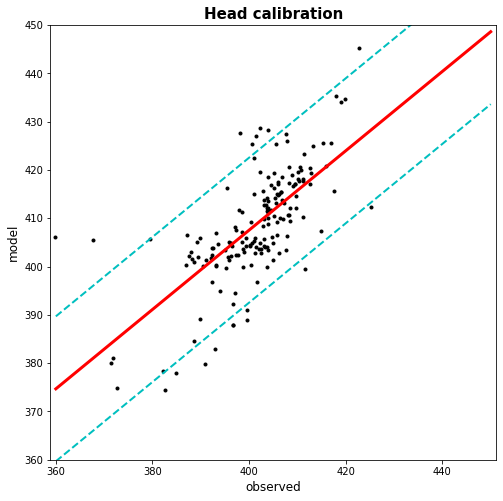

Slope = 0.821194043720837 
R-squared = 0.689


In [104]:
"Create the calibration plot."
plt.figure(figsize=[8,8],facecolor="white")
plt.plot(dfhisthead["y1995"],dfhisthead["model"],'.k',markersize=6)
plt.xlabel('observed',fontsize=12)
plt.ylabel('model',fontsize=12)
plt.axis("equal")
plt.title('Head calibration',fontsize=15,fontweight='bold')

def linline(x, a, b):
    return a + b * x

para, conv = spo.curve_fit(linline, dfhisthead["y1995"],dfhisthead["model"])
# z = np.polyfit(dfhisthead["y1995"],dfhisthead["model"], 1,conv=True)
correlation = np.corrcoef(dfhisthead["y1995"],dfhisthead["model"])[0,1]
xx=np.linspace(360,450,90)

plt.plot(xx, linline(xx,para[0],para[1]), '-r', linewidth=3)
plt.plot(xx, linline(xx,para[0],para[1])+15, '--c', linewidth=2)
plt.plot(xx, linline(xx,para[0],para[1])-15, '--c', linewidth=2)
plt.xlim(xx[0], xx[-1])
plt.ylim(xx[0], xx[-1])
plt.show()
print("Slope =",para[1],"\nR-squared =", round(correlation,3))

In [105]:
"""
kvc = 30 # predominantly very coarse
kc = 1.5   # predominantly coarse 
kf = 0.02  # predominantly fine
kb = 20  # bedrock
threshold1 = 61  # anything above this will be assigned kc and below kf
threshold2 = 40 # anything above this will be assigned kvc and below kc
slope=0.852 
def linline(x, a, b):
    return a + b * x

def kloader(rastername, k1, k2, threshold):
    percent = Raster.load(rastername)  # load raster
    percent.crop([(swx, swy), (swx, ney), (nex, ney),
                  (nex, swy)])  # crop array
    percentgrid = percent.resample_to_grid(
        xarr, yarr, 1, method='nearest')  # resample to model grid
    percentgrid = np.flipud(percentgrid)  # flip the grid
    maxrow = percentgrid.shape[0]
    maxcol = percentgrid.shape[1]
    for row in np.arange(maxrow, 0, -1):
        for col in np.arange(maxcol, 0, -1):
            if percentgrid[row - 1, col - 1] < -10:
                percentgrid[row - 1, col - 1] = percentgrid[row - 1, col]
    for row in np.arange(maxrow, 0, -1):
        for col in np.arange(maxcol, 0, -1):
            if percentgrid[row - 1, col - 1] >= threshold:
                percentgrid[row - 1, col - 1] = k1  # assign very coarse k value
                continue
            else:
                percentgrid[row - 1, col - 1] = k2
    return percentgrid

for ss in (np.arange(0.001,0.0035,0.0005)):
# assign hydrualic conductivity in ft/day

# determine how to assign hydrualic conductivity


  kl1 = kloader('percentl1.tif', kc, kf, threshold1)
  kl2 = kloader('percentl2.tif', kc, kf, threshold1)
  kl3 = kloader('percentl3.tif', kc, kf, threshold1)
  kl4 = kloader('percentl4.tif', kc, kf, threshold1)
  kl5 = kloader('percentl5.tif', kc, kf, threshold1)   
  kl6 = kloader('percentl6.tif', kc, kf, threshold1)
  kl7 = kloader('percentl7.tif', kc, kf, threshold1)
  kl8 = kloader('percentl8.tif', kvc, kc, threshold2)
  kl9 = kloader('percentl9.tif', kvc, kc, threshold2)
  kl10 = kl9 - kl9 + kb

  khlayers = [kl1, kl2, kl3, kl4, kl5, kl6, kl7, kl8, kl9, kl10]
  kvlayers = np.divide(khlayers, 10.)

  # Create a MODFLOW model object and run with MODFLOW 2005.
  modelname = "my_model"  # name the model
  m = flopy.modflow.Modflow(modelname, version='mf2005',
                            exe_name='mf2005')  # create model object m

  # length and time are feet (1) and days (4).
  # See https://water.usgs.gov/ogw/modflow/MODFLOW-2005-Guide/index.html?dis.htm 
  dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                                delr=dx, delc=dy, top=topgrid, botm=botgrids, 
                                itmuni = 4, lenuni = 1, 
                                nper=nper, steady=steady)

  #Create flopy bas object
  bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=topgrid)

  #define layer type as convertible (1) or confined (0), must be an integer
  laytyp = np.zeros((nlay, ), dtype=np.int32)
  #print(laytyp)  # result: [0 0 0 0 0 0 0 0 0 0]
  # create the LPF object
  lpf = flopy.modflow.ModflowLpf(model=m,
                                hk=khlayers,
                                vka=kvlayers,
                                laytyp=laytyp,
                                ipakcb=1)
  rech = kl1.copy()
  # Assume recharge is proportional to the conductivity. 

  rech = np.where(rech == kc, 2*ss, ss)
  # ibound_zero = ibound[0]
  ibound_zero = np.where(ibound[0] == 0)
  # ibound_zero_col = np.where(ibound_zero == 0)[1]
  for i in range(len(ibound_zero[0])):
      rech[ibound_zero[0][i], ibound_zero[1][i]] = 0
  # assign recharge to the model
  rch = flopy.modflow.mfrch.ModflowRch(model=m,nrchop=1,rech=rech)

  # put into a format that MODFLOW wants
  arriv = dfriv.values
  riverdata = {0: arriv}
  # create river package
  riv = flopy.modflow.mfriv.ModflowRiv(model=m,
                                      ipakcb=None,
                                      stress_period_data=riverdata)
  ardrn = dfdrn.values
  draindata = {0: ardrn}
  # create drain package
  riv = flopy.modflow.mfdrn.ModflowDrn(model=m,
                                      ipakcb=None,
                                      stress_period_data=draindata)
  pumpagedata = {0: pumplist}
  pum = flopy.modflow.mfwel.ModflowWel(model=m,
                                      ipakcb=None,
                                      stress_period_data=pumpagedata)

  #create oc stress period data.
  spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}
  #create output control object
  oc = flopy.modflow.ModflowOc(model=m, stress_period_data=spd, compact=True)

  # We will start by using the PCG solver with default settings
  #pcg = flopy.modflow.ModflowPcg(model=m)
  pcg = flopy.modflow.ModflowPcg(model=m,
                                mxiter=200,
                                iter1=50,
                                hclose=1e-03,
                                rclose=1e-03,
                                relax=0.98,
                                damp=0.3)

  # Write the model input
  m.write_input()
  # Execute the model run
  success, mfoutput = m.run_model(pause=False, report=False)
  # Report back if the model did not successfully complete
  if not success:
      raise Exception('MODFLOW did not terminate normally.')

  headobj = flopy.utils.binaryfile.HeadFile(modelname + '.hds')
  #extract head data from head object
  head = headobj.get_data(totim=1.0)
  # Set heads of inactivated cells to NAN (for plotting purpose)
  head1=np.where(head[0]<0,np.nan,head[0])
  head1=np.flipud(head1)  # data was upside down, let's flip it.
  model=[]
  for index, row in dfhisthead.iterrows():
    model.append(head1[int(row["row"])][int(row["col"])])
  dfhisthead['model']=model
  dfhisthead=dfhisthead.dropna(how='any')

  para, conv = spo.curve_fit(linline, dfhisthead["y1995"],dfhisthead["model"])
  correlation = np.corrcoef(dfhisthead["y1995"],dfhisthead["model"])[0,1]
  print(para[1])
  if (para[1]>slope and para[1]<=1):
    slope=para[1]
    KVC=ss
    core=correlation

print("Best is",slope,KVC,'R2 =',core)
"""

'\nkvc = 30 # predominantly very coarse\nkc = 1.5   # predominantly coarse \nkf = 0.02  # predominantly fine\nkb = 20  # bedrock\nthreshold1 = 61  # anything above this will be assigned kc and below kf\nthreshold2 = 40 # anything above this will be assigned kvc and below kc\nslope=0.852 \ndef linline(x, a, b):\n    return a + b * x\n\ndef kloader(rastername, k1, k2, threshold):\n    percent = Raster.load(rastername)  # load raster\n    percent.crop([(swx, swy), (swx, ney), (nex, ney),\n                  (nex, swy)])  # crop array\n    percentgrid = percent.resample_to_grid(\n        xarr, yarr, 1, method=\'nearest\')  # resample to model grid\n    percentgrid = np.flipud(percentgrid)  # flip the grid\n    maxrow = percentgrid.shape[0]\n    maxcol = percentgrid.shape[1]\n    for row in np.arange(maxrow, 0, -1):\n        for col in np.arange(maxcol, 0, -1):\n            if percentgrid[row - 1, col - 1] < -10:\n                percentgrid[row - 1, col - 1] = percentgrid[row - 1, col]\n   